In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag="v0.3.1");

ArgumentError: ArgumentError: Package InstantiateFromURL not found in current path:
- Run `import Pkg; Pkg.add("InstantiateFromURL")` to install the InstantiateFromURL package.


In [2]:
using LinearAlgebra, Statistics, Compat

In [24]:
# Exercise 2

using Parameters
using Plots

function simulate_y_t(params)
    @unpack θ, γ, σ, t_max, y₀ = params
    
    y = zeros(t_max+1)
    y_rolling_avg = zeros(t_max) # pre-allocate as length of each simulation is determined
    
    y[1] = y₀ # start at the initial value
    for t in 1:t_max
        y[t+1] = γ + θ * y[t] + σ * randn()
        y_rolling_avg[t] = mean(y[2:t+1]) # exclude y₀
    end
    return push!(y_rolling_avg, y[end])
end

simulate_y_t (generic function with 1 method)

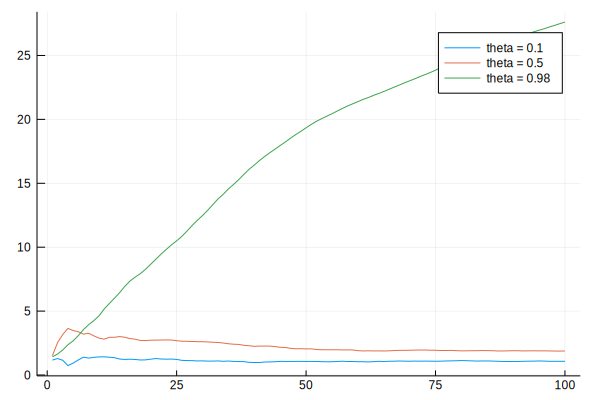

In [25]:
# setup default parameters
paramgen = @with_kw (θ=0.1, γ=1.0, σ=1.0, t_max=100, y₀=0.0)

θs = [0.1 0.5 0.98]
p = plot() # name a plot to add
for θ in θs
    result = simulate_y_t(paramgen(θ=θ)) # result contains rolling averages and the ending value of each simulation
    plot!(result[1:end-1], label = "theta = $θ") 
end
p # display plot for rolling means

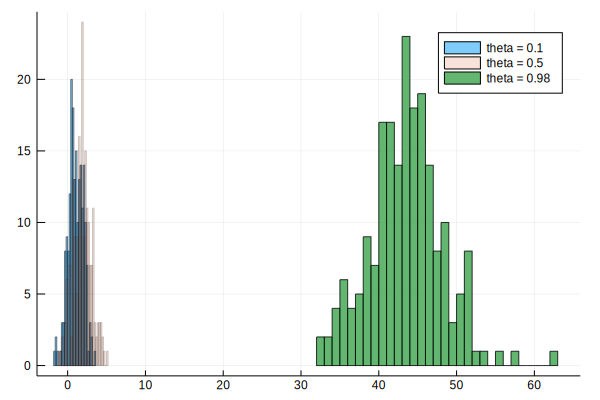

In [27]:
simulate_many_y_t(params, N) = [simulate_y_t(params) for _ in 1:N] # for multiple simulations
N = 200 # number of simulations

q = plot()

r1 = hcat(simulate_many_y_t(paramgen(), N)...)
histogram!(r1[101,:], nbins = 30, alpha =0.5, label = "theta = 0.1") # row 101 stores y_T for N simulations

r2 = hcat(simulate_many_y_t(paramgen(θ=0.5), N)...)
histogram!(r2[101,:], nbins = 30, alpha =0.2, label = "theta = 0.5")

r3 = hcat(simulate_many_y_t(paramgen(θ=0.98), N)...)
histogram!(r3[101,:], nbins = 30, alpha =0.8, label = "theta = 0.98")

q # display plot for stationary distribution

# Question: instead of hcat, is there other way to reshape the output for plots or way to avoid Array{Array{Float64,1},1}?

In [29]:
@show ymean = (mean(r1[101,:]), mean(r2[101,:]), mean(r3[101,:])) # mean of stationary distibution for θ = 0.1, 0.5, 0.98
@show yvar = (var(r1[101,:]), var(r2[101,:]), var(r3[101,:])) # variance of stationary distibution for θ = 0.1, 0.5, 0.98

ymean = (mean(r1[101, :]), mean(r2[101, :]), mean(r3[101, :])) = (1.0519346016667859, 1.926053767487068, 43.55102676165498)
yvar = (var(r1[101, :]), var(r2[101, :]), var(r3[101, :])) = (0.9342685441091501, 1.3306588987099615, 22.24981633544132)


(0.9342685441091501, 1.3306588987099615, 22.24981633544132)

In [14]:
# Exercise 3

function myOLS(params)
    @unpack a, b, c, d, σ, N = params
    
    x1 = randn(N)
    x2 = randn(N)
    w  = randn(N)
    y  = similar(x1)
    @. y  = a*x1 + b*x1^2 + c*x2 + d + σ*w
    
    X = [x1 x1.^2 x2 ones(N)]
    estimate = (X' * X) \ (X' * y) # OLS
    residual = y - X * estimate
    estimate_σ = (residual' * residual)/(N-4)
    return push!(estimate, estimate_σ)
end

mymultipleOLS(params, M) = [myOLS(params) for _ in 1:M] # for multiple simulations

# setup parameters
paramgen = @with_kw (a=0.1, b=0.2, c=0.5, d=1.0, σ=0.1, N=50)
M = 20

estimate = hcat(mymultipleOLS(paramgen(), M)...) 
# Question: other way to reshape the output into matrix for plots or way to avoid Array{Array{Float64,1},1}?

5×20 Array{Float64,2}:
 0.116939   0.0901036  0.0844408   …  0.109858    0.104187   0.101344  
 0.187934   0.22007    0.214547       0.220281    0.203922   0.1949    
 0.487941   0.495898   0.462664       0.514697    0.511279   0.515769  
 1.01768    0.97325    0.971557       0.966514    1.01226    1.00895   
 0.0098068  0.0116533  0.00915184     0.00686251  0.0142805  0.00893903

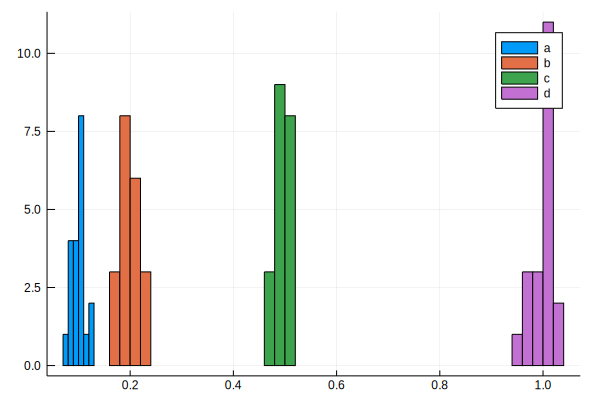

In [16]:
r = plot()
histogram!(estimate[1,:], label = "a")
histogram!(estimate[2,:], label = "b")
histogram!(estimate[3,:], label = "c")
histogram!(estimate[4,:], label = "d")
r # display plot for coefficients

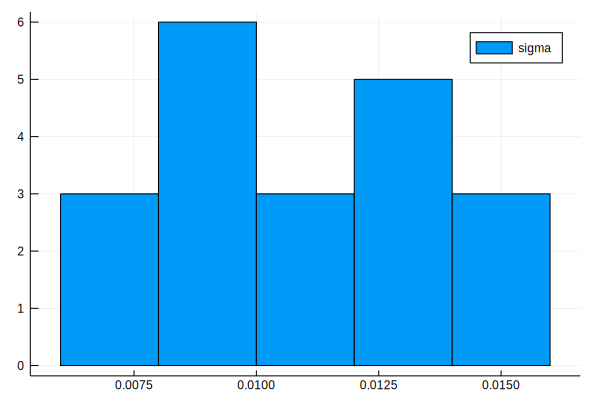

In [23]:
histogram(estimate[5,:], nbins = 5, label = "sigma") # display plot for σ